# Platoon Finding

This document aims to demonstrate the "platoon" phenomenon in a portion of the WIM data. Using years 2014-2016 in the Cereni, Denges and Gotthard stations. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

The function below takes an input of station name and lanes and finds the single lane platoons by comparing the timestamps of the two trucks and categorizing any trucks with timestamps of less than 3 seconds appart as in a platoon. Platoons of two or more were then combined if the headway between the last of the group is within 3 seconds. The composition of the truck types are kept and aggregated into a list. The top 5 occuring lists are then displayed for platoons of lengths 2, 3 and 4.

In [60]:
#Takes in the station and the number of the inner lanes in both directions for the period of 2014-2016
def one_lane_platoon(Station, start_y, end_y, lanes, mode):
    df = pd.read_csv('{}Data/{}_{}_datetime.csv'.format(Station, start_y, end_y), index_col=0, parse_dates=['Date'])    
    
    #For each lane in lanes, find the individual platoon histogram and most common platoon combinations
    df_platoon = []
    for lane in lanes:
        df_lane = df.loc[df['FS'] == lane]

        df_lane = df_lane.set_index('Date')
        df_lane = df_lane.sort_index()
        df_lane['HEAD_T'] =(df_lane.index.to_series().shift(-1) - df_lane.index.to_series()).dt.total_seconds() #Truck headway

        threshold_selector = df_lane.HEAD_T > 3 #defines a headway of three seconds as the threshold
        groups = threshold_selector.cumsum()
        df_lane['Start']  = df_lane.index.to_series()
        df_lane['End'] = df_lane.index.to_series()
        df_lane_platoon = df_lane.groupby(groups).agg({'Start':min, 'End':max, 'CLASS': lambda x: x.tolist(), 'GW_TOT': lambda x: x.tolist(), 'LENTH': lambda x: x.tolist(), })
        df_lane_platoon['Platoon'] = (df_lane_platoon.CLASS.str.len() > 1)
        df_lane_platoon['Length'] = df_lane_platoon.CLASS.str.len()
        df_plot = df_lane_platoon[df_lane_platoon.Length > 1]
        df_plot['Length'].plot.hist(bins=10, title= "{} Lane {} Platoon Frequencies Greater than 1 {}-{}".format(Station, lane, start_y, end_y)) 
        plt.show()
        if mode:
            #Display the combinations of platoons that are the most common for 2, 3 and 4 length
            print(df_lane_platoon[df_lane_platoon.Length == 2].CLASS.apply(tuple).value_counts().head().to_string())
            print(df_lane_platoon[df_lane_platoon.Length == 3].CLASS.apply(tuple).value_counts().head().to_string())
            print(df_lane_platoon[df_lane_platoon.Length == 4].CLASS.apply(tuple).value_counts().head().to_string())
        df_lane_platoon['Lane'] = int(lane)
        df_platoon.append(df_lane_platoon)
        
    return df_platoon

In [109]:
def truck_type_filter(df):
    
    overweight = list(map(str, range(41, 47)))    #List of overwieght truck classes that can be replaced to single overweight class
    medium = ['1128', '1127']
    long = ['11117', '11127', '12117']
    
    df_class = df[['Length', 'CLASS']].explode('CLASS')
    df_class['CLASS'] = df_class.CLASS.astype(str)
    df_class['CLASS'] = df_class.CLASS.replace(overweight, '41 - 46')
    df_class['CLASS'] = df_class.CLASS.replace(medium, '112r/112a')
    df_class['CLASS'] = df_class.CLASS.replace(long, '1111r/1112r/1211r')
    df_class['Length'] = df_class['Length'].apply(lambda x: str(x) if x <= 4 else '5 +')
    df_class_grouped = df_class.groupby(['Length', 'CLASS']).CLASS.count()
    df_class_grouped = df_class_grouped.unstack(-1)
    df_class_grouped = df_class_grouped.fillna(0)
    df_class_grouped = df_class_grouped.append(df_class_grouped.sum().rename('Total'))
    df_class_grouped = df_class_grouped.div(df_class_grouped.sum(1), axis=0)
    return df_class_grouped


def truck_type_graph(df, lane, station):

    #First plot the entire breakdown of the classes
    if lane:
        lanes = df.Lane.unique()
        for single in lanes:
            df_lane = df.loc[df['Lane'] == single]
            df_lane = truck_type_filter(df_lane)
            f = plt.figure()
            df_lane.plot(kind='bar', stacked=True,title='{} Lane {} class breakdown depending on platoon length'.format(station, single),
                                 colormap='Set3').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
            plt.show()
            
    df_total = truck_type_filter(df)

    f = plt.figure()
    df_total.plot(kind='bar', stacked=True,title='{} total class breakdown depending on platoon length'.format(station),
                         colormap='Set3').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

![](StationLanes/Denges.PNG=100x20)

Below is the Denges WIM station representation.
<img src="StationLanes/Denges.PNG" width="300">

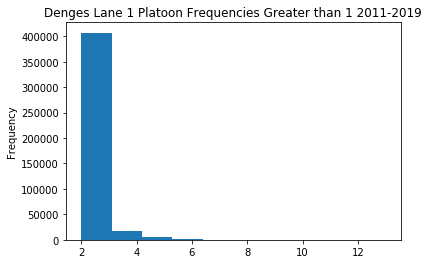

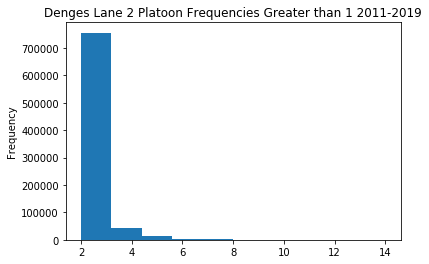

In [79]:
station = 'Denges'
df_station = one_lane_platoon(station, 2011, 2019, [1, 2], False)
df_station = pd.concat(df_station,ignore_index=True)
df_station.to_csv('{}Data/2011_2019_platoon.csv'.format(station))

In [117]:
station = "Denges"
df_station.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

In [ ]:
station = "Denges"
df_denges = pd.read_pickle('{}Data/2011_2019_platoon.pkl'.format(station), index_col=0, parse_dates=['Start', 'End'])
df_denges.head()

In [ ]:
truck_type_graph(df_denges, True, station)

Below is the Ceneri WIM station representation.
<img src="StationLanes/Ceneri.PNG" width="300">

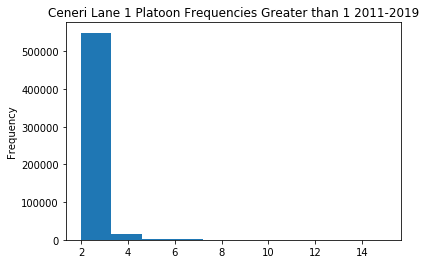

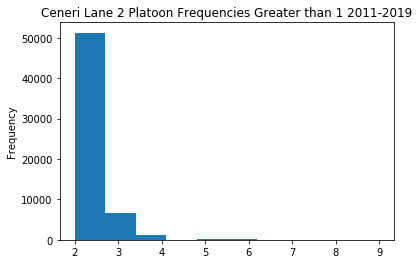

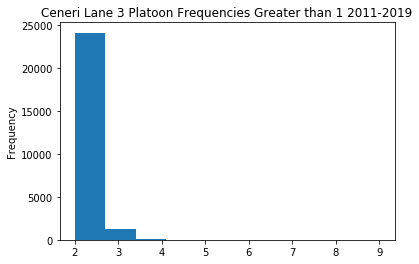

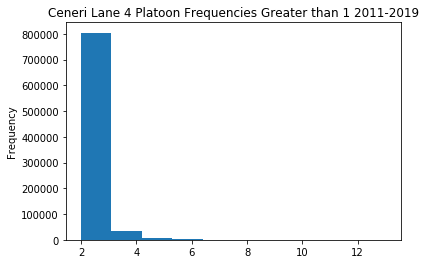

In [61]:
df_ceneri = one_lane_platoon("Ceneri", 2011, 2019, [1, 2, 3, 4], False)

In [62]:
df_ceneri = pd.concat(df_ceneri, ignore_index=True)

In [115]:
station = "Ceneri"

In [116]:
df_ceneri.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

<Figure size 432x288 with 0 Axes>

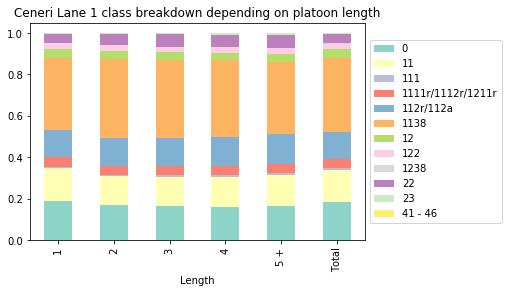

<Figure size 432x288 with 0 Axes>

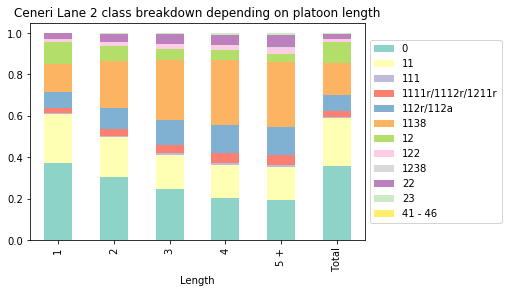

<Figure size 432x288 with 0 Axes>

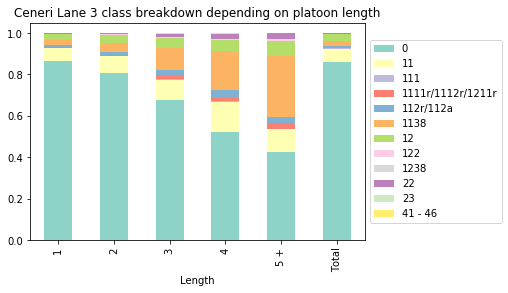

<Figure size 432x288 with 0 Axes>

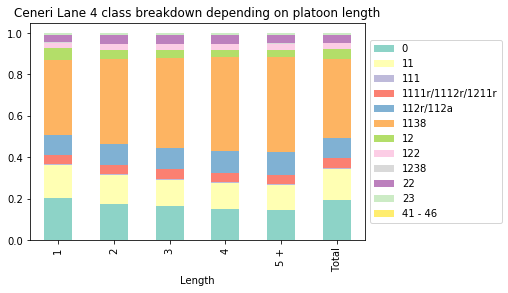

<Figure size 432x288 with 0 Axes>

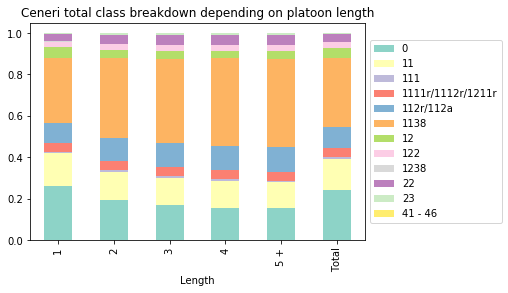

In [112]:
truck_type_graph(df_ceneri, True, station)

Below is the Gotthard WIM station representation.
<img src="StationLanes/Gotthard.PNG" width="300">

In [ ]:
station = 'Gotthard'
df_station = one_lane_platoon(station, 2011, 2019, [1, 2], False)

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df_station = pd.concat(df_station, ignore_index=True)
df_station.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

In [ ]:
truck_type_graph(df_station, True, station)

In [ ]:
df_station.head()

In [ ]:
station = "Gotthard"
df_got = pd.read_csv('{}Data/2011_2019_platoon.csv'.format(station), index_col=0, parse_dates=['Start', 'End'])
truck_type_graph(df_got, True, station)

# Multiple Lane Platoon

Here is a 